In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from gymnasium import spaces
from tqdm import trange
from torch import nn
from torch_geometric.data import Data, Batch

from notebooks.datasets.SP100Stocks import SP100Stocks
from notebooks.models import A3TGCN
from notebooks.ppo import PPO

# S&P100 weights optimization via Deep Reinforcement Learning
The goal of this notebook is to build an agent capable of learning the optimal weights for the S&P100 index that give the best returns. The agent will try to outperform an equally weighted portfolio, meaning that each stock has the same weight.
## Important note:
### Unfortunately, this task uses high computational power and time, and I do not have the necessary resources to train the model. The code is provided as an example of how to implement a reinforcement learning agent to optimize the stock weights of a portfolio. The code has been tested for few epochs, which were not enough.

## Loading the data
The data from the custom PyG dataset for containing the historical prices and the graph structure of the stocks is loaded.
For this task, a longer time series than the previous ones is needed. Here 200 days of data is considered, which corresponds to 40 weeks.

In [2]:
episode_duration = 200
seq_len = 25
dataset = SP100Stocks(past_window=seq_len)
dataset, dataset[0]

(SP100Stocks(1208),
 Data(x=[100, 5, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

The data is split into a training and testing set. The testing contains the last `seq_len` days of the dataset. The training set contains the rest of the data.

In [3]:
# train_episodes has the shape (n_episodes, episode_duration, n_stocks, n_features, seq_len)
train_episodes = [
	dataset[i:i+episode_duration] for i in trange(0, len(dataset)-episode_duration, 10, desc='Creating training episodes', position=0)
]
random.shuffle(train_episodes)

test_episode = dataset[-episode_duration:]
len(train_episodes), train_episodes[0], test_episode

Creating training episodes: 100%|██████████| 101/101 [00:28<00:00,  3.58it/s]


(101, SP100Stocks(200), SP100Stocks(200))

## Reinforcement Learning Environment
The environment is defined using the Gymnasium API.
- State

The observations are the graphs of the stocks at each time step, where nodes contain data on the last `n` days (variation, price, RSI, ...).
- Action

The action space is a continuous space of size (n_stocks,) where the agent can choose the weights for each stock. We need $\sum_{i=1}^{n} a_i = 1$, where $a_i$ is the weight of stock $i$. A simple way to achieve this is to apply a softmax on the received action.
- Reward

The goal of the agent is to beat the baseline, which is an equally weighted portfolio. The reward is a function of the difference between the agent's performance and the baseline's performance. The reward is calculated with a sigmoid function as follows:
$$
r = \left( \frac{1}{1 + e^{b - a}} - 0.5 \right) \times c
$$
where $b$ is the baseline performance, $a$ is the agent's performance, and $c$ is a reward coefficient.

In [20]:
class SP100Env(gym.Env):
	metadata = {'render.modes': ['human']}
	def __init__(self, n_stocks: int, n_edges: int, n_features, seq_len: int, train_episodes: list[SP100Stocks], test_episode: SP100Stocks, render_mode: str = None, reward_coef: float = 50):
		super(SP100Env, self).__init__()
		self.n_stocks: int = n_stocks
		self.n_features: int = n_features
		self.seq_len: int = seq_len
		self.episode_length: int = len(train_episodes[0]) - 1  # -1 because the next day is needed to calculate the reward
		self.reward_coef: float = reward_coef
		
		self.train_episodes: list[SP100Stocks] = train_episodes
		self.test_episode: list[SP100Stocks] = test_episode
		
		self.current_episode: SP100Stocks = train_episodes[0]
		self.current_step: int = 0
		
		assert render_mode is None or render_mode in self.metadata["render_modes"]
		self.render_mode: str = render_mode

		self.action_space: spaces.Box = spaces.Box(low=0, high=1, shape=(n_stocks,), dtype=np.float32)
		self.observation_space: spaces.Dict = spaces.Dict({
			'x': spaces.Box(low=-np.inf, high=np.inf, shape=(n_stocks, n_features, seq_len), dtype=np.float32),
			'edge_index': spaces.Box(low=0, high=n_stocks-1, shape=(2, n_edges), dtype=np.int64),
	    'edge_weight': spaces.Box(low=-np.inf, high=np.inf, shape=(n_edges,), dtype=np.float32),
		})
		
		self.baseline_weights: np.ndarray = np.ones(n_stocks) / n_stocks
		self.current_baseline_performance: float = 1.
		self.current_agent_performance: float = 1.
		
	def reset(self, seed=None, options=None) -> dict:
		if options and options.get("test", False):
			self.current_episode = self.test_episode
		else:
			self.current_episode = random.choice(self.train_episodes)
		self.current_step = 0
		self.current_baseline_performance = 1.
		self.current_agent_performance = 1.
		
		self.render()
		return self._get_observation(), {}
	
	def step(self, action: np.ndarray) -> tuple[dict, float, bool, dict]:
		action = np.exp(action) / np.sum(np.exp(action))  # softmax to ensure weights sum to 1
		assert self.action_space.contains(action)
		assert action.shape == (self.n_stocks,)
		
		
		next_day_variations = self.current_episode[self.current_step + 1].x[:, 2, -1].numpy() / 100  # variations are in percentage
		
		baseline_variations = np.sum(next_day_variations * self.baseline_weights)
		agent_variations = np.sum(next_day_variations * action)
		
		self.current_baseline_performance *= (1 + baseline_variations)
		self.current_agent_performance *= (1 + agent_variations)
				
		self.current_step += 1
		observation = self._get_observation()
		reward = self._get_reward(baseline_variations, agent_variations)
		terminated = self.current_step >= self.episode_length
		
		self.render()
		
		if terminated:
			self.reset()
		
		return observation, reward, terminated, False, {}
	
	def render(self) -> None:
		if self.render_mode == 'human':
			print(f'Current step: {self.current_step}/{self.episode_length}')
			print(f'Baseline performance: {self.current_baseline_performance}')
			print(f'Agent performance: {self.current_agent_performance}')

	def close(self):
		pass
	
	def _get_observation(self) -> dict:
		return {
			'x': self.current_episode[self.current_step].x.numpy(),
			'edge_index': self.current_episode[self.current_step].edge_index.numpy(),
			'edge_weight': self.current_episode[self.current_step].edge_weight.numpy(),
		}
	
	def _get_reward(self, step_baseline_performance: float, step_agent_performance: float) -> float:
		return (1 / (1 + np.exp(step_baseline_performance - step_agent_performance)) - 1) * self.reward_coef

In [21]:
n_stocks, n_edges, n_features = dataset[0].x.shape[0], dataset[0].edge_index.shape[1], dataset[0].x.shape[1]

env = SP100Env(n_stocks=n_stocks, n_edges=n_edges,n_features=n_features, seq_len=seq_len, train_episodes=train_episodes, test_episode=test_episode)

## Defining the agent
The agent uses the A3T-GCN model. The action space is a continuous space of size (n_stocks,). An Actor-Critic model is used. The actor will output a Gaussian distribution with a mean and a standard deviation of size (n_stocks,). The critic will output the value of the state.

In [22]:
class Actor(nn.Module):
	def __init__(self, n_stocks: int, n_features: int, hidden_size: int, layers_nb: int):
		super(Actor, self).__init__()
		self.mean = A3TGCN(n_features, 1, hidden_size, layers_nb)
		self.logstd = nn.Parameter(torch.zeros(n_stocks))
	
	def forward(self, obs: Data | Batch) -> tuple[torch.tensor, torch.tensor]:
		return self.mean(obs.x, obs.edge_index, obs.edge_weight).view(obs.num_graphs, -1), torch.exp(self.logstd)

In [23]:
class Critic(nn.Module):
	def __init__(self, n_stocks: int, n_features: int, hidden_size: int, layers_nb: int):
		super(Critic, self).__init__()
		self.value = A3TGCN(n_features, 1, hidden_size, layers_nb)
		self.out = nn.Linear(n_stocks, 1)
	
	def forward(self, obs: Data | Batch) -> torch.tensor:
		values = self.value(obs.x, obs.edge_index, obs.edge_weight).view(obs.num_graphs, -1)
		return self.out(values)

## Instantiating the agent & algorithm

In [24]:
hidden_size = 16
actor_lr, critic_lr = 5e-3, 1e-2

actor = Actor(n_stocks, n_features, hidden_size, 2)
critic = Critic(n_stocks, n_features, hidden_size, 2)

ppo = PPO(config={
	"env_fn": lambda: SP100Env(n_stocks=n_stocks, n_edges=n_edges, n_features=n_features, seq_len=seq_len, train_episodes=train_episodes, test_episode=test_episode),
	"num_envs": 2,
	
	"actor_model": actor,
	"critic_model": critic,
	
	"horizon": 16,
})

## Training

In [25]:
ppo.train(max_steps=1_000, task_title="S&P100WeightsOptimization")

==== STARTING TRAINING ====


PPO Training: 100%|██████████| 1000/1000 [19:14<00:00,  1.15s/it] 


==== TRAINING COMPLETE ====


## Evaluation
The trained agent is tested on the testing set.

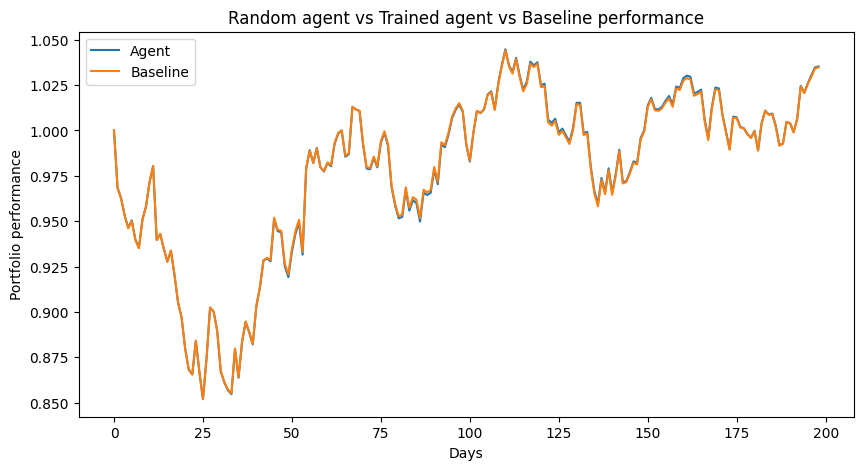

In [26]:
agent_performance, baseline_performance = [], []

obs, _ = env.reset()
done = False

while not done:
	agent_performance.append(env.current_agent_performance)
	baseline_performance.append(env.current_baseline_performance)

	action = ppo.compute_single_action(obs, {})
	obs, _, done, _, _ = env.step(action)
		
plt.figure(figsize=(10, 5))
plt.plot(agent_performance, label='Agent')
plt.plot(baseline_performance, label='Baseline')
plt.xlabel('Days')
plt.ylabel('Portfolio performance')
plt.title('Random agent vs Trained agent vs Baseline performance')
plt.legend()
plt.show()